In [28]:
# Setting up the Colab page to use neqsim
%%capture
!pip install neqsim
from neqsim.process import openprocess
import urllib
import time
# Importing the TEG process from file
!wget https://github.com/equinor/neqsimprocess/raw/master/lib/offshorePro.neqsim

#Documentation
https://github.com/equinor/neqsimprocess/blob/master/doc/oilstabilizationprocess.pdf


In [29]:
# importing the process from the stored file
# See: https://github.com/equinor/neqsimprocess/blob/master/src/neqsimprocess/oilgasprocess/sepproces.java
# See Figure 1 for process flow diagram
GasOilProcess = openprocess('offshorePro.neqsim')

## figure oil process
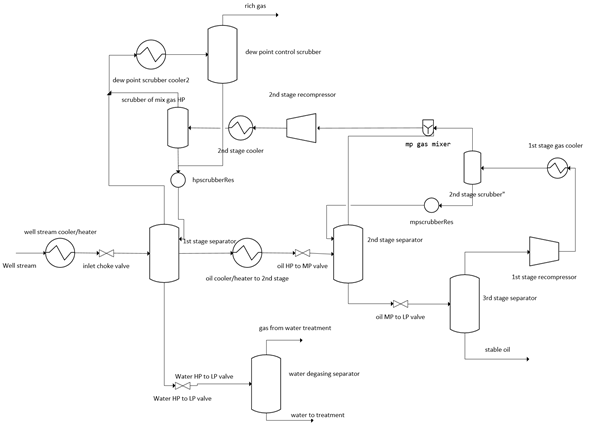

In [30]:
from neqsim.process import openprocess
import time
import pandas as pd
from neqsim.thermo import createfluid,fluid_df,TPflash
# Read gas-oil process from file

# Create alternativ well stream
#wellStreamComposition = {'ComponentName':  ["nitrogen", "CO2", "methane", "ethane", "propane", "i-butane", "n-butane", "i-pentane", "n-pentane", "n-hexane", "C7", "C8", "C9", "C10", "C11", "C12", "C13", "C14", "C15", "C16", "C17", "C18", "C19", "C20", "water"], 
#        'MolarComposition[-]':  [0.53, 3.3, 72.98, 7.68, 4.1, 0.7, 1.42, 0.54, 0.67, 0.85, 1.33, 1.33, 0.78, 0.61, 0.42, 0.33, 0.42, 0.24, 0.3, 0.17, 0.21, 0.15, 0.15, 0.8, 10.0], 
#        'MolarMass[kg/mol]': [None,None, None,None,None,None,None,None,None,None,0.0913, 0.1041, 0.1188, 0.136, 0.150, 0.164, 0.179, 0.188, 0.204, 0.216, 0.236, 0.253, 0.27, 0.391, None],
#        'RelativeDensity[-]': [None,None, None,None,None,None,None,None,None,None, 0.746, 0.768, 0.79, 0.787, 0.793, 0.804, 0.817, 0.83, 0.835, 0.843, 0.837, 0.84, 0.85, 0.877, None]
#  } 
#
#wellStreamCompositiondf = pd.DataFrame(wellStreamComposition) 
#wellStream = fluid_df(wellStreamCompositiondf)
#GasOilProcess.getUnit("well stream").setThermoSystem(wellStream)

GasOilProcess.getUnit("well stream").setFlowRate(12.23, 'MSm3/day')
GasOilProcess.getUnit("well stream").setPressure(120.0, "bara")
GasOilProcess.getUnit("well stream").setTemperature(65.0, "C")
GasOilProcess.getUnit("well stream cooler/heater").setOutTemperature(66.0, "C")
GasOilProcess.getUnit("well stream cooler/heater").setOutPressure(52.21, "bara")
GasOilProcess.getUnit("inlet choke valve").setOutletPressure(51.21, "bara")
GasOilProcess.getUnit("1st stage separator").setEntrainment(0.1, "", "oil", "aqueous")
GasOilProcess.getUnit("oil HP to MP valve").setOutletPressure(15.0, "bara")
GasOilProcess.getUnit("oil cooler/heater to 2nd stage").setOutTemperature(40.0, "C")
GasOilProcess.getUnit("oil MP to LP valve").setOutletPressure(1.8, "bara")
GasOilProcess.getUnit("Water HP to LP valve").setOutletPressure(1.01325, "bara")
GasOilProcess.getUnit("dew point scrubber cooler2").setOutTemperature(30.0, "C")
GasOilProcess.getUnit("1st stage recompressor").setIsentropicEfficiency(0.75)
GasOilProcess.getUnit("2nd stage recompressor").setIsentropicEfficiency(0.75)



In [31]:
#Run the process calculations
tic = time.perf_counter()
GasOilProcess.run()
toc = time.perf_counter()
print(f"Simulation run in {toc - tic:0.4f} seconds")

Simulation run in 3.1409 seconds


In [41]:
#Read results
GasLiqidRatio = GasOilProcess.getUnit("rich gas").getFluid().getFlowRate("Sm3/hr")/GasOilProcess.getUnit("stable oil").getFluid().getFlowRate("m3/hr")
compressorPower1 = GasOilProcess.getUnit("1st stage recompressor").getPower()/1.0e3
compressorPower2 = GasOilProcess.getUnit("2nd stage recompressor").getPower()/1.0e3
cooler1Duty = GasOilProcess.getUnit("1st stage gas cooler").getDuty()/1e3
cooler2Duty = GasOilProcess.getUnit("2nd stage cooler").getDuty()/1e3

wellStreamFLowMSm3day = GasOilProcess.getUnit("well stream").getFluid().getFlowRate("MSm3/day")
richGasFLowMSm3day = GasOilProcess.getUnit("rich gas").getFluid().getFlowRate("MSm3/day")
gasInletSepFlowMSm3day = GasOilProcess.getUnit("1st stage separator").getGasOutStream().getFluid().getFlowRate("MSm3/day")
stableOilFLowm3hr = GasOilProcess.getUnit("stable oil").getFluid().getFlowRate("m3/hr")
waterToTreatmentRatem3hr = GasOilProcess.getUnit("water to treatment").getFluid().getFlowRate("m3/hr")
resycleFLowDewPointScrubber = GasOilProcess.getUnit("dew point control scrubber").getLiquidOutStream().getFluid().getFlowRate("kg/hr")
GOR=GasOilProcess.getUnit("rich gas").getFluid().getFlowRate("Sm3/hr")/ GasOilProcess.getUnit("stable oil").getFluid().getFlowRate("m3/hr")

In [42]:
print("rich gas flow", richGasFLowMSm3day, " MSm3/day")
print("1st stage recompressor power", compressorPower1, " kW")
print("2nd stage recompressor power", compressorPower2, " kW")
print("1st stage gas cooler duty ", cooler1Duty, " kW")
print("2nd stage cooler duty ", cooler2Duty, " kW")
print("stable oil production ", stableOilFLowm3hr, " me/hr")
print("rich gas production ", richGasFLowMSm3day, " MS3/day")
print("GOR ", GOR)

rich gas flow 4.253029840962406  MSm3/day
1st stage recompressor power 5360.678452078049  kW
2nd stage recompressor power 7272.8309904473  kW
1st stage gas cooler duty  -11438.968030901582  kW
2nd stage cooler duty  -16398.064248968734  kW
stable oil production  3087.468970579832  me/hr
rich gas production  4.253029840962406  MS3/day
GOR  57.39639115255194


#Case study - effect of second stage pressure/temperature
In the following simulation we will evaluate the effect of second stage pressure/temperature on total compressor power.


Text(0, 0.5, 'Power [kW]')

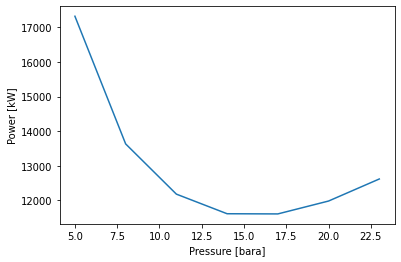

In [34]:
import numpy as np
import matplotlib.pyplot as plt

minPressure = 5.0  #@param {type:"number"}
maxPressure = 25.0  #@param {type:"number"}
pressure = np.arange(minPressure, maxPressure, int((maxPressure-minPressure)/10)+1)

def casestudypressure(pressure):
  GasOilProcess.getUnit("oil HP to MP valve").setOutletPressure(pressure, "bara")
  GasOilProcess.run()
  compressorPower1 = GasOilProcess.getUnit("1st stage recompressor").getPower()/1.0e3
  compressorPower2 = GasOilProcess.getUnit("2nd stage recompressor").getPower()/1.0e3
  totalPower = compressorPower1+compressorPower2
  return totalPower

totalpower = [casestudypressure(P) for P in pressure]

plt.figure()
plt.plot(pressure, totalpower)
plt.xlabel('Pressure [bara]')
plt.ylabel('Power [kW]')


Text(0, 0.5, 'Power [kW]')

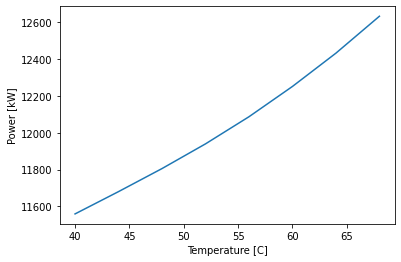

In [35]:
minTemperature = 40.0  #@param {type:"number"}
maxTemperature = 70.0  #@param {type:"number"}
temperature = np.arange(minTemperature, maxTemperature, int((maxTemperature-minTemperature)/10)+1)
GasOilProcess.getUnit("oil HP to MP valve").setOutletPressure(15.0 , "bara")

def casestudytemperature(temperature):
  GasOilProcess.getUnit("oil cooler/heater to 2nd stage").setOutTemperature(temperature, "C")
  GasOilProcess.run()
  compressorPower1 = GasOilProcess.getUnit("1st stage recompressor").getPower()/1.0e3
  compressorPower2 = GasOilProcess.getUnit("2nd stage recompressor").getPower()/1.0e3
  totalPower = compressorPower1+compressorPower2
  return totalPower

totalpower = [casestudytemperature(T) for T in temperature]

plt.figure()
plt.plot(temperature, totalpower)
plt.xlabel('Temperature [C]')
plt.ylabel('Power [kW]')